In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import random


In [26]:

nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")


scaler = StandardScaler()
scaled_values = scaler.fit_transform(nodes_df[['publication_count', 'citation_count']])

author_encoder = LabelEncoder()
nodes_df['author_index'] = author_encoder.fit_transform(nodes_df['author_id'])
nodes_df['institution_encoded'] = LabelEncoder().fit_transform(nodes_df['institution'])

edges_df['source_index'] = author_encoder.transform(edges_df['source_author_id'])
edges_df['target_index'] = author_encoder.transform(edges_df['target_author_id'])

x_features = np.hstack((scaled_values, nodes_df[['institution_encoded']].values))
x = torch.tensor(x_features, dtype=torch.float)
edge_index = torch.tensor(edges_df[['source_index', 'target_index']].values.T, dtype=torch.long)

data = Data(x=x, edge_index=edge_index)


In [27]:
class LinkPredictorWithMLP(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        from torch_geometric.nn import GCNConv

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.dropout = nn.Dropout(0.3)

        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

    def decode(self, z, edge_index):
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        z_pair = torch.cat([z_src, z_dst], dim=1)
        return self.mlp(z_pair).squeeze()

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)


In [28]:
pos_edge_index = data.edge_index
neg_edge_index = negative_sampling(
    edge_index=pos_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=pos_edge_index.size(1)
)

edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
edge_label = torch.cat([
    torch.ones(pos_edge_index.size(1)),
    torch.zeros(neg_edge_index.size(1))
])


In [29]:
model = LinkPredictorWithMLP(in_channels=3, hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-5)

for epoch in range(1, 401):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x, data.edge_index, edge_label_index)
    loss = F.binary_cross_entropy_with_logits(pred, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 20, Loss: 0.3305
Epoch 40, Loss: 0.2826
Epoch 60, Loss: 0.1666
Epoch 80, Loss: 0.1275
Epoch 100, Loss: 0.1526
Epoch 120, Loss: 0.1398
Epoch 140, Loss: 0.1109
Epoch 160, Loss: 0.1071
Epoch 180, Loss: 0.1055
Epoch 200, Loss: 0.1145
Epoch 220, Loss: 0.0890
Epoch 240, Loss: 0.0789
Epoch 260, Loss: 0.0909
Epoch 280, Loss: 0.1124
Epoch 300, Loss: 0.0829
Epoch 320, Loss: 0.0650
Epoch 340, Loss: 0.0778
Epoch 360, Loss: 0.0606
Epoch 380, Loss: 0.0536
Epoch 400, Loss: 0.0774


In [30]:
model.eval()
with torch.no_grad():
    preds = model(data.x, data.edge_index, edge_label_index)
    probs = torch.sigmoid(preds)
    predicted_labels = (probs > 0.5).float()

y_true = edge_label.cpu().numpy()
y_pred = predicted_labels.cpu().numpy()
y_score = probs.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC Score:", roc_auc_score(y_true, y_score))


Accuracy: 0.9850277264325323
F1 Score: 0.9851321585903083
AUC Score: 0.9985594896833071


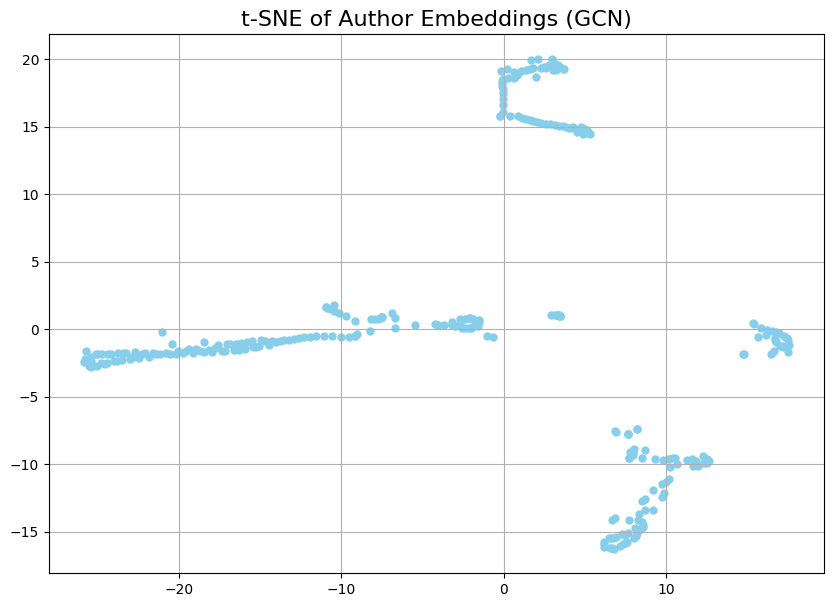

In [31]:
with torch.no_grad():
    node_embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='skyblue', s=25)
plt.title("t-SNE of Author Embeddings (GCN)", fontsize=16)
plt.grid(True)
plt.show()


In [41]:
# All existing edges
existing = set([tuple(sorted([a.item(), b.item()])) for a, b in zip(data.edge_index[0], data.edge_index[1])])

# Generate candidate author pairs that are NOT connected
candidates = []
for i in range(data.num_nodes):
    for j in range(i + 1, data.num_nodes):
        if (i, j) not in existing:
            candidates.append((i, j))

# Sample top 1000 for prediction
sampled = random.sample(candidates, 1000)
edge_label_index = torch.tensor(sampled).T

In [42]:
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.edge_index)
    scores = torch.sigmoid(model.decode(z, edge_label_index))

# Top 10 most likely collaborations
top_scores, top_indices = torch.topk(scores, 10)
top_pairs = edge_label_index[:, top_indices].T

for score, (src, tgt) in zip(top_scores, top_pairs):
    author1 = nodes_df[nodes_df['author_index'] == src.item()]['display_name'].values[0]
    author2 = nodes_df[nodes_df['author_index'] == tgt.item()]['display_name'].values[0]
    print(f"{author1} || {author2}  |  Likelihood: {score.item():.4f}")


Piotr Dollár || Antony Lee  |  Likelihood: 0.9938
Ilya Sutskever || Alan Bridge  |  Likelihood: 0.9933
Sebastian W. Bodenstein || Agata Laydon  |  Likelihood: 0.9906
Hanzi Mao || Anne M. Archibald  |  Likelihood: 0.9855
Ilya Sutskever || Kamal Chikh Echioukh  |  Likelihood: 0.9819
Christopher Hesse || M. Rodríguez-López  |  Likelihood: 0.9471
Mike Lewis || Monya Baker  |  Likelihood: 0.9462
Vivian Welch || Tim Green  |  Likelihood: 0.9382
Heng Li || Hong-Yuan Mark Liao  |  Likelihood: 0.9353
Mahdi Mahmoudy || Lorna Richardson  |  Likelihood: 0.9216
